### Convolutional Neural Networks 2

The previous notebook went over how we built and trained a CNN.

In this notebook, we'll cover how we make predictions and get the top likely hotels that the model thinks an image came from.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import shutil

In [3]:
tf.random.set_seed(42)

In [4]:
!mkdir kaggle_dataset

In [5]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/kaggle_dataset'

In [ ]:
!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

In [7]:
!chmod 600 /content/kaggle_dataset/kaggle.json

In [8]:
!kaggle competitions download -c hotel-id-2021-fgvc8 --force

100% 24.4G/24.4G [05:10<00:00, 170MB/s]
100% 24.4G/24.4G [05:10<00:00, 84.4MB/s]


In [ ]:
!unzip hotel-id-2021-fgvc8.zip -d /content/kaggle_dataset/hotels/

In [10]:
train_df = pd.read_csv('/content/kaggle_dataset/hotels/train.csv')
train_df = train_df.drop_duplicates(subset=['image'], keep='first')

In [ ]:
folders = [str(chain) for chain in range(0, 92)]
dir = "/content/kaggle_dataset/hotels/train_images/"
hotels_dir = f"/content/kaggle_dataset/hotels/train_images_by_id/"
for folder in folders:
  chain_path = dir + folder + '/'
  if os.path.exists(chain_path):
    for file in os.listdir(chain_path):
      if file.endswith('.jpg'):
        hotel_id = str(train_df[train_df['image'] == file]['hotel_id'].values[0])
        hotel_dir = hotels_dir + hotel_id
        if not os.path.exists(hotel_dir):
          os.makedirs(hotel_dir)
        if os.path.exists(hotel_dir):
          file_path = chain_path + file
          shutil.move(file_path, hotel_dir)

In [15]:
!mkdir /content/kaggle_dataset/hotels/batches

In [16]:
# moves from hotel id folders to batches
dir = "/content/kaggle_dataset/hotels/train_images_by_id/"
batches_dir = "/content/kaggle_dataset/hotels/batches/"
id_count = 0
batch = 1
for root, dirs, files in os.walk(dir, topdown=False):
  id_count += 1
  batch_dir = f'batch_{batch}/'
  batch_directory = batches_dir + batch_dir
  if not os.path.exists(batch_directory):
    os.makedirs(batch_directory)
  if id_count <= 500:
    hotel_id = root.split('/')[-1]
    batch_hotel_dir = f'{batch_directory}{hotel_id}/' 
    if not os.path.exists(batch_hotel_dir):
      os.makedirs(batch_hotel_dir)
    if os.path.exists(batch_hotel_dir):
      for file in files:
        shutil.move(root + '/' + file, batch_hotel_dir)
  else:
    batch += 1
    id_count = 0

In [18]:
def get_batchsets(batch_num):
  batch_size = 32
  img_height = 56
  img_width = 56
  hotels_dir = f"/content/kaggle_dataset/hotels/batches/batch_{batch_num}/"
  train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    hotels_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    subset='training',
    validation_split=0.2,
    label_mode='int'
  )
  val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  hotels_dir,
  validation_split=0.2,
  subset='validation',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='int'
)
  return (train_ds, val_ds)

In [19]:
train_ds, val_ds = get_batchsets(1)
train_ds

Found 6324 files belonging to 500 classes.
Using 5060 files for training.
Found 6324 files belonging to 500 classes.
Using 1264 files for validation.


<BatchDataset shapes: ((None, 56, 56, 3), (None,)), types: (tf.float32, tf.int32)>

In [20]:
class_names = train_ds.class_names
num_classes = len(class_names)

In [22]:
def cache_ds(train_ds, val_ds):
  AUTOTUNE = tf.data.AUTOTUNE
  train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
  return(train_ds, val_ds)

In [23]:
train_ds, val_ds = cache_ds(train_ds, val_ds)

In [67]:
class ConvNet:
  models = []
  best_model = None
  best_acc = 0
  def __init__(self, cFilters=[(64,0)], dLayers=[(800,0,0)]):
    self.hyperparameters = {
        'cFilters': cFilters,
        'dLayers': dLayers,
        'dropouts': dropouts
    }
    self.create_model(cFilters, dLayers)
    
  def create_model(self, cFilters, dLayers):
    model = tf.keras.Sequential()
    model.add(layers.experimental.preprocessing.Rescaling(1./255))
    model.add(layers.experimental.preprocessing.RandomFlip('horizontal'))
    model.add(layers.experimental.preprocessing.RandomZoom(0.2))
    model.add(layers.experimental.preprocessing.RandomRotation(0.1))
    model.add(layers.experimental.preprocessing.CenterCrop(28, 28))
    for cFilter, reg in cFilters:
      model.add(layers.Conv2D(cFilter, 3, padding='same', activation='relu', kernel_regularizer=l2(reg)))
      model.add(layers.MaxPooling2D(padding='valid'))
    model.add(layers.Flatten())
    for dLayer, reg, drop in dLayers:
      model.add(layers.Dense(dLayer, activation='relu', kernel_regularizer=l2(reg)))
      model.add(layers.Dropout(drop))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(
      optimizer='adam',
      loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'])
    self.model = model
  def fit(self, train_ds, val_ds, epochs=100, batch_size=16):
    history = self.model.fit(train_ds, validation_data=val_ds, epochs=epochs, batch_size=batch_size)
    best_acc = max(history.history['val_accuracy'])
    print('best acc', best_acc)
    if best_acc > ConvNet.best_acc:
      ConvNet.best_acc = best_acc
      ConvNet.best_model = self
    ConvNet.models.append(self.model)
    ConvNet.hyperparameters.append(self.hyperparameters)
    self.history = history
    return history

### Create and train the model

More details in the previous notebook - agiver_hotel_cnn_1

In [ ]:
conv_man = ConvNet([(100, 0), (32, 0)], [(400, 0, 0.6), (200, 0, 0.5)])
conv_man_hist = conv_man.fit(train_ds, val_ds, 100)

### Images from the validation set

Pull some images from the validation set to go through the process of making predictions and being able to evaluate how the model performs in greater detail.

Below we're showing an image from hotel 23694, which has a distinctive blue bed runner thing. We hypothesized that the model would do better at identifying this hotel since it is distinctive enough to stand out.

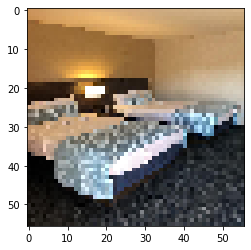

In [162]:
test_image_8899 = '/content/kaggle_dataset/hotels/batches/batch_1/8899/e5781c034e1f764d.jpg' #8899
test_image_28103 = '/content/kaggle_dataset/hotels/batches/batch_1/28103/8783c06c9e5ccd9d.jpg'
test_image_650 = '/content/kaggle_dataset/hotels/batches/batch_1/650/e0e11b16ee1939e6.jpg'
test_image_23694 = '/content/kaggle_dataset/hotels/batches/batch_1/23694/83b226c8b887c9f7.jpg'
test_images = [test_image_8899, test_image_28103, test_image_650, test_image_23694]

img = tf.keras.preprocessing.image.load_img(test_image_23694, target_size=(56, 56))
plt.imshow(img)

### Get predictions function

This function will pull the top most likely hotels from which the images came.

In [190]:
def get_predictions(model, img_paths=[], top=5):
  predictions=[]
  for img_path in img_paths:
    testing_img = tf.keras.preprocessing.image.load_img(img_path, target_size=(56, 56)) 
    img_array = tf.keras.preprocessing.image.img_to_array(testing_img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    preds = model.predict(img_array)
    score = tf.nn.softmax(preds[0])
    print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    ind = np.argpartition(score, top*-1)[top*-1:]
    
    tops = [class_names[i] for i in ind]
    conf = [100*np.array(score)[i] for i in ind]
    tops_conf = list(zip(tops, conf))
    tops_conf.sort(key=lambda tup: tup[1], reverse=True)
    predictions.append(tops_conf)
  return predictions

### Predictions made

In the cell below, the model was tasked to provide its best 5 guesses for the provided images. 
The correct answers are:

        8899
        28103
        650
        23694

Guesses are returned in order from most confident to least confident.

As hypothesized, the model identified the hotel of the room with the blue bedspread! It was most confident about this room with 0.4% confidence.

However, perhaps this isn't too much to celebrate, as it also predicted that same hotel for the third test image.

Still, it was most confident about that prediction. It looks our model did learn something after all.

Results summary:

<table>
    <thead>
        <th>Image</th>
        <th>Guessed correctly</th>
        <th>Which guess</th>
        <th>Confidence</th>
    </thead>
    <tr>
        <td>One</td>
        <td>Yes</td>
        <td>3</td>
        <td>0.20685866475105286</td>
    </tr>
    <tr>
        <td>Two</td>
        <td>No</td>
        <td>N/A</td>
        <td>N/A</td>
    </tr>
    <tr>
        <td>Three</td>
        <td>No</td>
        <td>N/A</td>
        <td>N/A</td>
    </tr>
    <tr>
        <td>Four</td>
        <td>Yes</td>
        <td>1</td>
        <td>0.3963327035307884</td>
    </tr>
</table>


In [191]:

preds = get_predictions(conv_man.model, test_images, 5)
preds

This image most likely belongs to 40441 with a 0.21 percent confidence.
This image most likely belongs to 11970 with a 0.23 percent confidence.
This image most likely belongs to 23694 with a 0.33 percent confidence.
This image most likely belongs to 23694 with a 0.40 percent confidence.


[[('40441', 0.2118562813848257),
  ('43375', 0.20826985128223896),
  ('49411', 0.20775208249688148),
  ('8899', 0.20685866475105286),
  ('30431', 0.2058209152892232)],
 [('11970', 0.22507940884679556),
  ('40697', 0.2222163137048483),
  ('24291', 0.22040356416255236),
  ('38112', 0.21757453214377165),
  ('44454', 0.21203137002885342)],
 [('23694', 0.33060512505471706),
  ('39554', 0.21355545613914728),
  ('34777', 0.20884997211396694),
  ('56397', 0.20864331163465977),
  ('14776', 0.2078925259411335)],
 [('23694', 0.3963327035307884),
  ('22719', 0.21887978073209524),
  ('56397', 0.20422872621566057),
  ('35518', 0.20302487537264824),
  ('14776', 0.2029401483014226)]]

### For the future

When we're ready to commmit to handling the entire dataset, this function is ready and waiting

In [203]:
def get_all():
  batch_size = 32
  img_height = 56
  img_width = 56
  hotels_dir = f"/content/kaggle_dataset/hotels/train_images_by_id/"
  train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    hotels_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    subset='training',
    validation_split=0.2,
    label_mode='int'
  )
  val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  hotels_dir,
  validation_split=0.2,
  subset='validation',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='int'
)
  return (train_ds, val_ds)